# EEG preprocessing 
### Effect of prediction and attention on C1 component
Written by Maximilien Van Migem
and Created on 22/11/2023 

## Set-up
Import necessary libraries

In [2]:
# Import some libraries
import os
import numpy as np
import mne
%matplotlib qt 

## Data
Import data

In [5]:
data_directory = 'C:/Users/mvmigem/Documents/data/project_1/'
current_file_path = data_directory + 'pilot/clara/eeg/main_clara.bdf'

raw = mne.io.read_raw_bdf(current_file_path, preload = True)

Extracting EDF parameters from C:\Users\mvmigem\Documents\data\project_1\pilot\clara\main_clara.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1465855  =      0.000 ...  2862.998 secs...


Data exploration

In [6]:
isinstance(raw.info, dict)

print(raw)
print(raw.info)

# The fields in .info are Python dictionary keys, indexed using square brackets
# and strings to access the contents. For example, to access the channel names:
print(raw.info['ch_names'])
print('there are {} channels'.format(len(raw.info['ch_names']))) # of channels
# the sampling frequency
print(raw.info['sfreq'])
# a list of channels labelled as 'bad' (should be empty for now)
print(raw.info['bads'])

<RawEDF | main_clara.bdf, 73 x 1465856 (2863.0 s), ~816.5 MB, data loaded>
<Info | 8 non-empty values
 bads: []
 ch_names: A1, A2, A3, A4, A5, A6, A7, A8, A9, A10, A11, A12, A13, A14, ...
 chs: 72 EEG, 1 Stimulus
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 104.0 Hz
 meas_date: 2024-03-07 11:02:48 UTC
 nchan: 73
 projs: []
 sfreq: 512.0 Hz
 subject_info: 1 item (dict)
>
['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20', 'A21', 'A22', 'A23', 'A24', 'A25', 'A26', 'A27', 'A28', 'A29', 'A30', 'A31', 'A32', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'B13', 'B14', 'B15', 'B16', 'B17', 'B18', 'B19', 'B20', 'B21', 'B22', 'B23', 'B24', 'B25', 'B26', 'B27', 'B28', 'B29', 'B30', 'B31', 'B32', 'EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'Status']
there are 73 channels
512.0
[]


Renaming and adressing the channels

In [7]:

# we rename the channels to their respective external electrodes
fix_chans = {'EXG1':'eye_above','EXG2':'eye_below',
             'EXG3':'eye_left','EXG4':'eye_right',
             'EXG5':'M1','EXG6':'M2'}
raw.rename_channels(fix_chans)

# we still have two exg channels which weren't actually recorded though (EXG7
# and EXG8) these are empty, so we'll drop them
raw.drop_channels(['EXG7', 'EXG8'])
print(raw.info['ch_names'])

# we'll also reset the channel types, so MNE knows what is 'brain' data
raw.set_channel_types({'M1':'eeg', 'M2':'eeg',
                       'eye_above':'eog', 'eye_below':'eog',
                       'eye_left':'eog', 'eye_right': 'eog'})

print(raw.info)

['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20', 'A21', 'A22', 'A23', 'A24', 'A25', 'A26', 'A27', 'A28', 'A29', 'A30', 'A31', 'A32', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'B13', 'B14', 'B15', 'B16', 'B17', 'B18', 'B19', 'B20', 'B21', 'B22', 'B23', 'B24', 'B25', 'B26', 'B27', 'B28', 'B29', 'B30', 'B31', 'B32', 'eye_above', 'eye_below', 'eye_left', 'eye_right', 'M1', 'M2', 'Status']
<Info | 8 non-empty values
 bads: []
 ch_names: A1, A2, A3, A4, A5, A6, A7, A8, A9, A10, A11, A12, A13, A14, ...
 chs: 66 EEG, 4 EOG, 1 Stimulus
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 104.0 Hz
 meas_date: 2024-03-07 11:02:48 UTC
 nchan: 71
 projs: []
 sfreq: 512.0 Hz
 subject_info: 1 item (dict)
>


### Reference, filter and deal with bad channels

In [8]:
# rereference to mastoids
raw.set_eeg_reference(ref_channels = ['M1','M2'])
raw.drop_channels(['M1','M2'])


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


<RawEDF | main_clara.bdf, 69 x 1465856 (2863.0 s), ~771.7 MB, data loaded>

Using matplotlib as 2D backend.


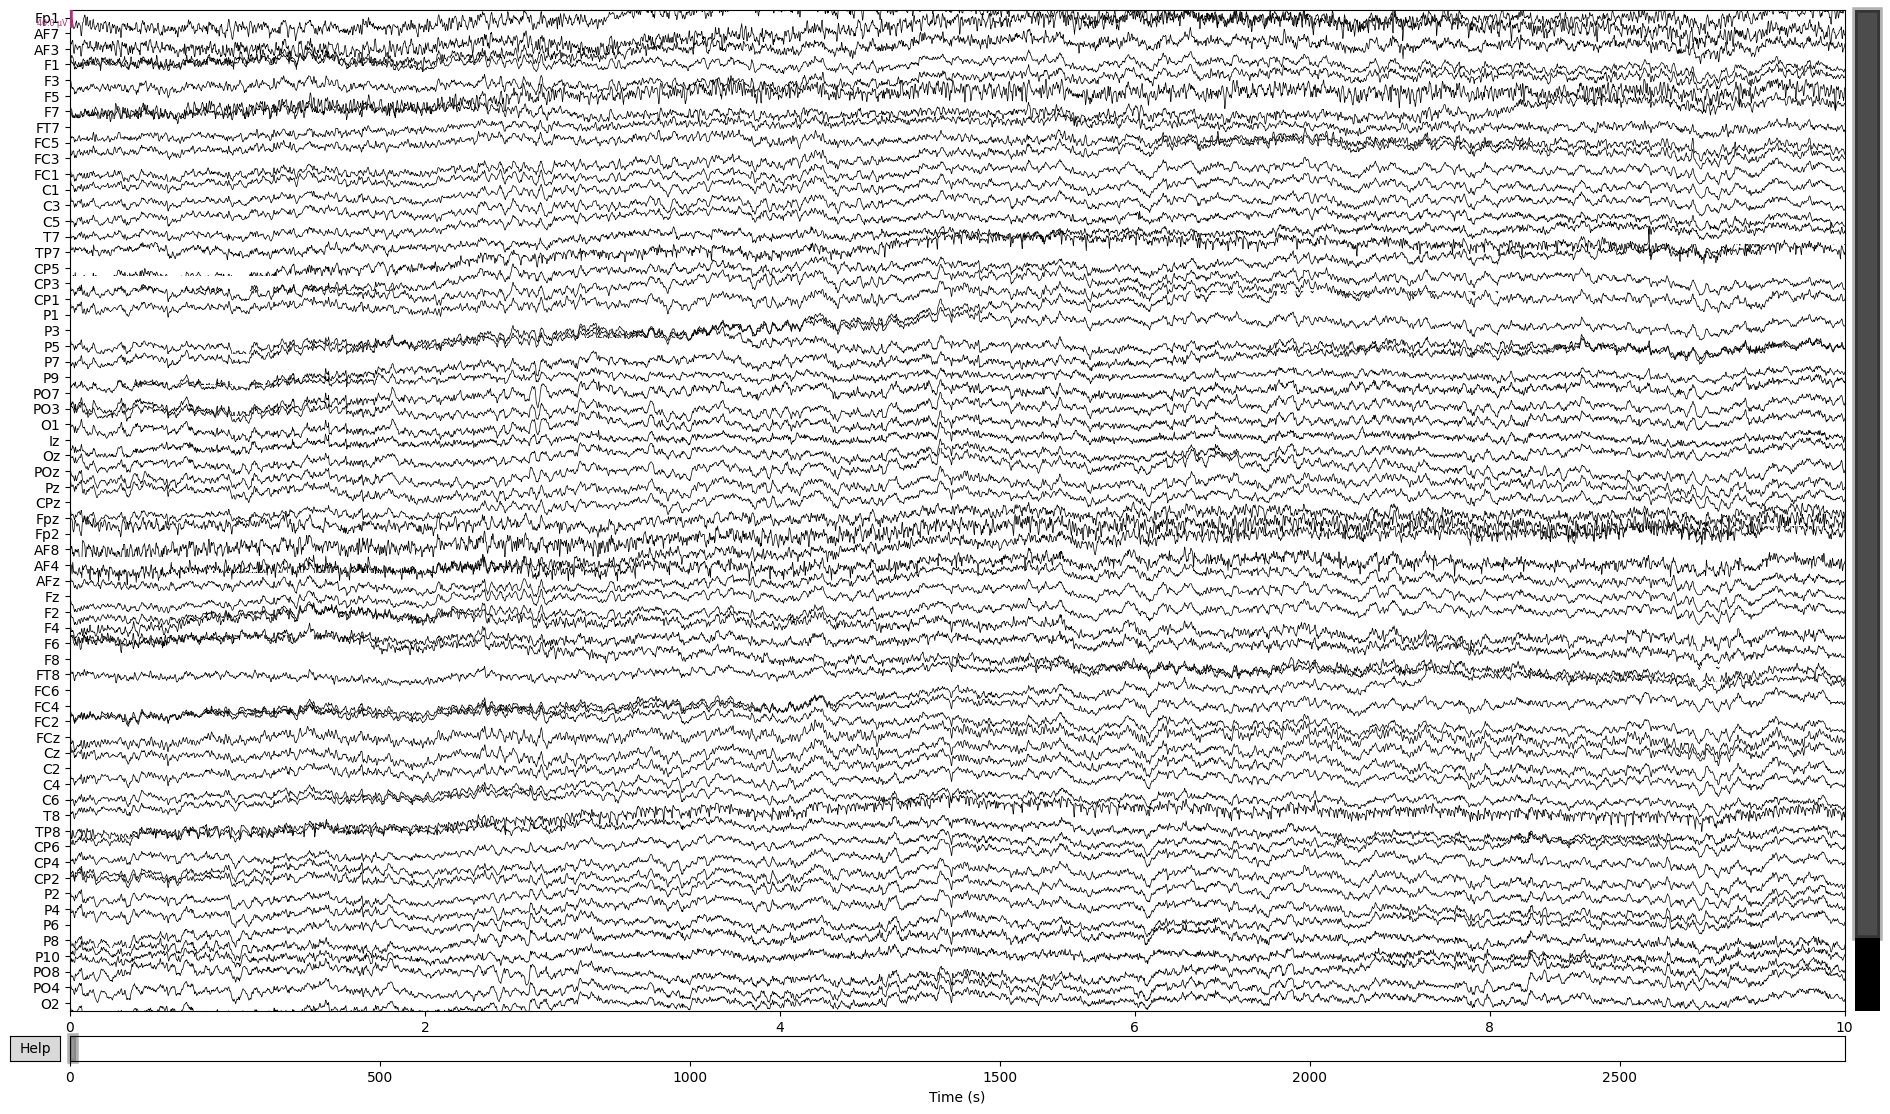

In [9]:
## I'll drop the mastoids because I'm not using them
# raw.drop_channels(['mastoid_left', 'mastoid_right'])
# Set montage
montage = mne.channels.make_standard_montage('biosemi64')
# Check the montage in 3d
montage.plot(kind = '3d')
# There is a mismatch between the names of the recording and the names of the montage
# This dict is to rename the channel names to fit the montage
mon_chnames = montage.ch_names
raw_chnames = raw.info['ch_names']
rename_channels = dict(zip(raw_chnames[:64],mon_chnames))
raw.rename_channels(rename_channels)
# Set montage
raw.set_montage(montage)
# take another look
raw.plot(n_channels = 64)



In [ ]:
raw.plot(n_channels=64)

In [10]:
# we can annotate bad spans of raw data in the interactive plot by pressing the
# 'a' key, useful if we know there is a period we aren't interested in such
# as a mis-start of the task etc.
raw_annot = raw.copy()

# we can also identify eog events algorithmically via "find_eog_events" this
# produces a list of 'events' around each blink (hopefully). This applies a 
# filter and then identifies peaks in the eog to find likely blinks. We can 
# adjust the threshold, via thresh. but default should be okay for now.
eog_events = mne.preprocessing.find_eog_events(raw_annot)
# we'll say that the blinks start a tiny bit earlier than 
onsets = eog_events[:, 0] / raw_annot.info["sfreq"] - 0.25
# we'll assume they're all half a second long
dur = [0.5] * len(eog_events)
descriptions = ["bad blink"] * len(eog_events)
blink_annot = mne.Annotations(onsets,
                              dur,
                              descriptions,
                              orig_time = raw_annot.info["meas_date"])
raw_annot.set_annotations(blink_annot)

# let's take a look at what has been detected


Using EOG channels: eye_above, eye_below, eye_left, eye_right
EOG channel index for this subject is: [64 65 66 67]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel eye_above for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 113 significant peaks
Number of EOG events detected: 113


<RawEDF | main_clara.bdf, 69 x 1465856 (2863.0 s), ~771.8 MB, data loaded>

In [ ]:
raw_annot.plot()

In [11]:
# Downsampling variables (logic -> https://mne.tools/stable/auto_tutorials/preprocessing/30_filtering_resampling.html#best-practices)
current_sfreq = raw.info['sfreq']
desired_sfreq = 256  # Hz
decim = np.round(current_sfreq / desired_sfreq).astype(int)
obtained_sfreq = current_sfreq / decim
lowpass_freq = obtained_sfreq / 3.


raw_filtered = raw_annot.copy().notch_filter(freqs = 50, fir_design = 'firwin', verbose=None, )
raw_filtered = raw_filtered.copy().filter(l_freq=0.1, h_freq=lowpass_freq)



Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3381 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 85 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 85.33 Hz
- Upper transition bandwidth: 21.33 Hz (-6 dB cutoff frequency: 96.00 Hz)
- Filter length: 16897 samples (33.002 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Setting 27842 of 1465856 (1.90%) samples to NaN, retaining 1438014 (98.10%) samples.
Effective window size : 4.000 (s)


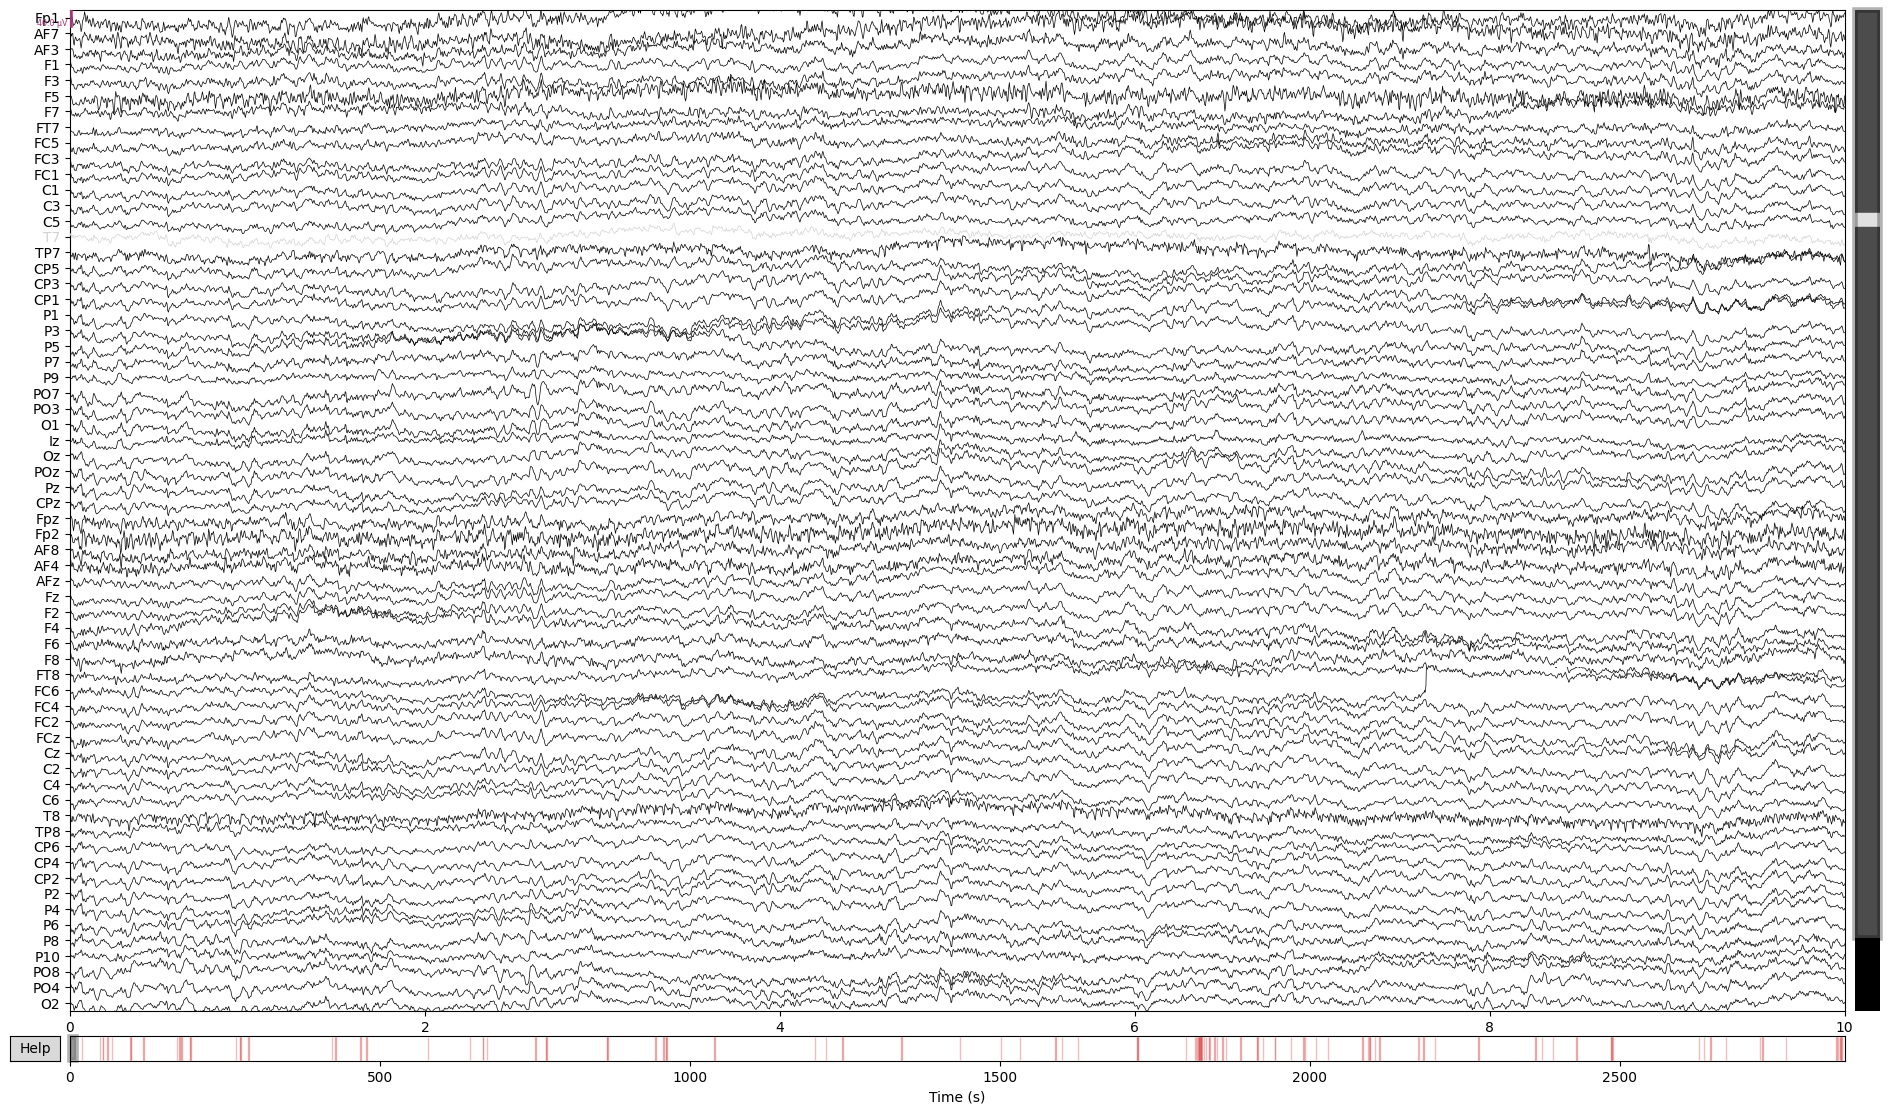

In [12]:
raw_filtered.plot_psd()
raw_filtered.plot(n_channels=64)


In [ ]:
print(raw_filtered.info['bads'])

# a butterfly plot overlays all of the channels, here we highlight the 'bad'
# channels by presenting them in a different colour. This can be helpful to 
# see how much that channel truly stands out.
fig = raw_filtered.plot(butterfly = True,
                    color = '#00000022',
                    bad_color = 'r',
                    title = 'bads_marked')




# plot sensor locations in 2d view
# 'bad' channels will be red, click individual dots to see the label
raw_filtered.plot_sensors()


In [13]:
interp_filt_raw = raw_filtered.copy().interpolate_bads(reset_bads = False)


Interpolating bad channels
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 63 sensor positions
Interpolating 1 sensors


In [15]:
events = mne.find_events(interp_filt_raw)
# Event dict
event_id = {
    'start_trial':99, 'pos1/seq2':12, 'pos1/seq4':14, 
    'pos2/seq1':21, 'pos2/seq3':23,
    'pos3/seq2':32, 'pos3/seq4':34,
    'pos4/seq1':41, 'pos4/seq3':43,
}


# we can visualise the paradigm (timecourse of the events), to confirm nothing
# weird has happened
fig = mne.viz.plot_events(events, 
                          sfreq = interp_filt_raw.info['sfreq'],
                          event_id = event_id)


Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
4271 events found
Event IDs: [   12    14    21    23    32    34    41    43    99   255 65536 65789
 65791]


C:\Users\mvmigem\AppData\Local\Temp\ipykernel_23436\3315049498.py:13: RuntimeWarning: event 255 missing from event_id will be ignored
  fig = mne.viz.plot_events(events,
C:\Users\mvmigem\AppData\Local\Temp\ipykernel_23436\3315049498.py:13: RuntimeWarning: event 65536 missing from event_id will be ignored
  fig = mne.viz.plot_events(events,
C:\Users\mvmigem\AppData\Local\Temp\ipykernel_23436\3315049498.py:13: RuntimeWarning: event 65789 missing from event_id will be ignored
  fig = mne.viz.plot_events(events,
C:\Users\mvmigem\AppData\Local\Temp\ipykernel_23436\3315049498.py:13: RuntimeWarning: event 65791 missing from event_id will be ignored
  fig = mne.viz.plot_events(events,
C:\Users\mvmigem\AppData\Local\Temp\ipykernel_23436\3315049498.py:13: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  fig = mne.viz.plot_events(events,


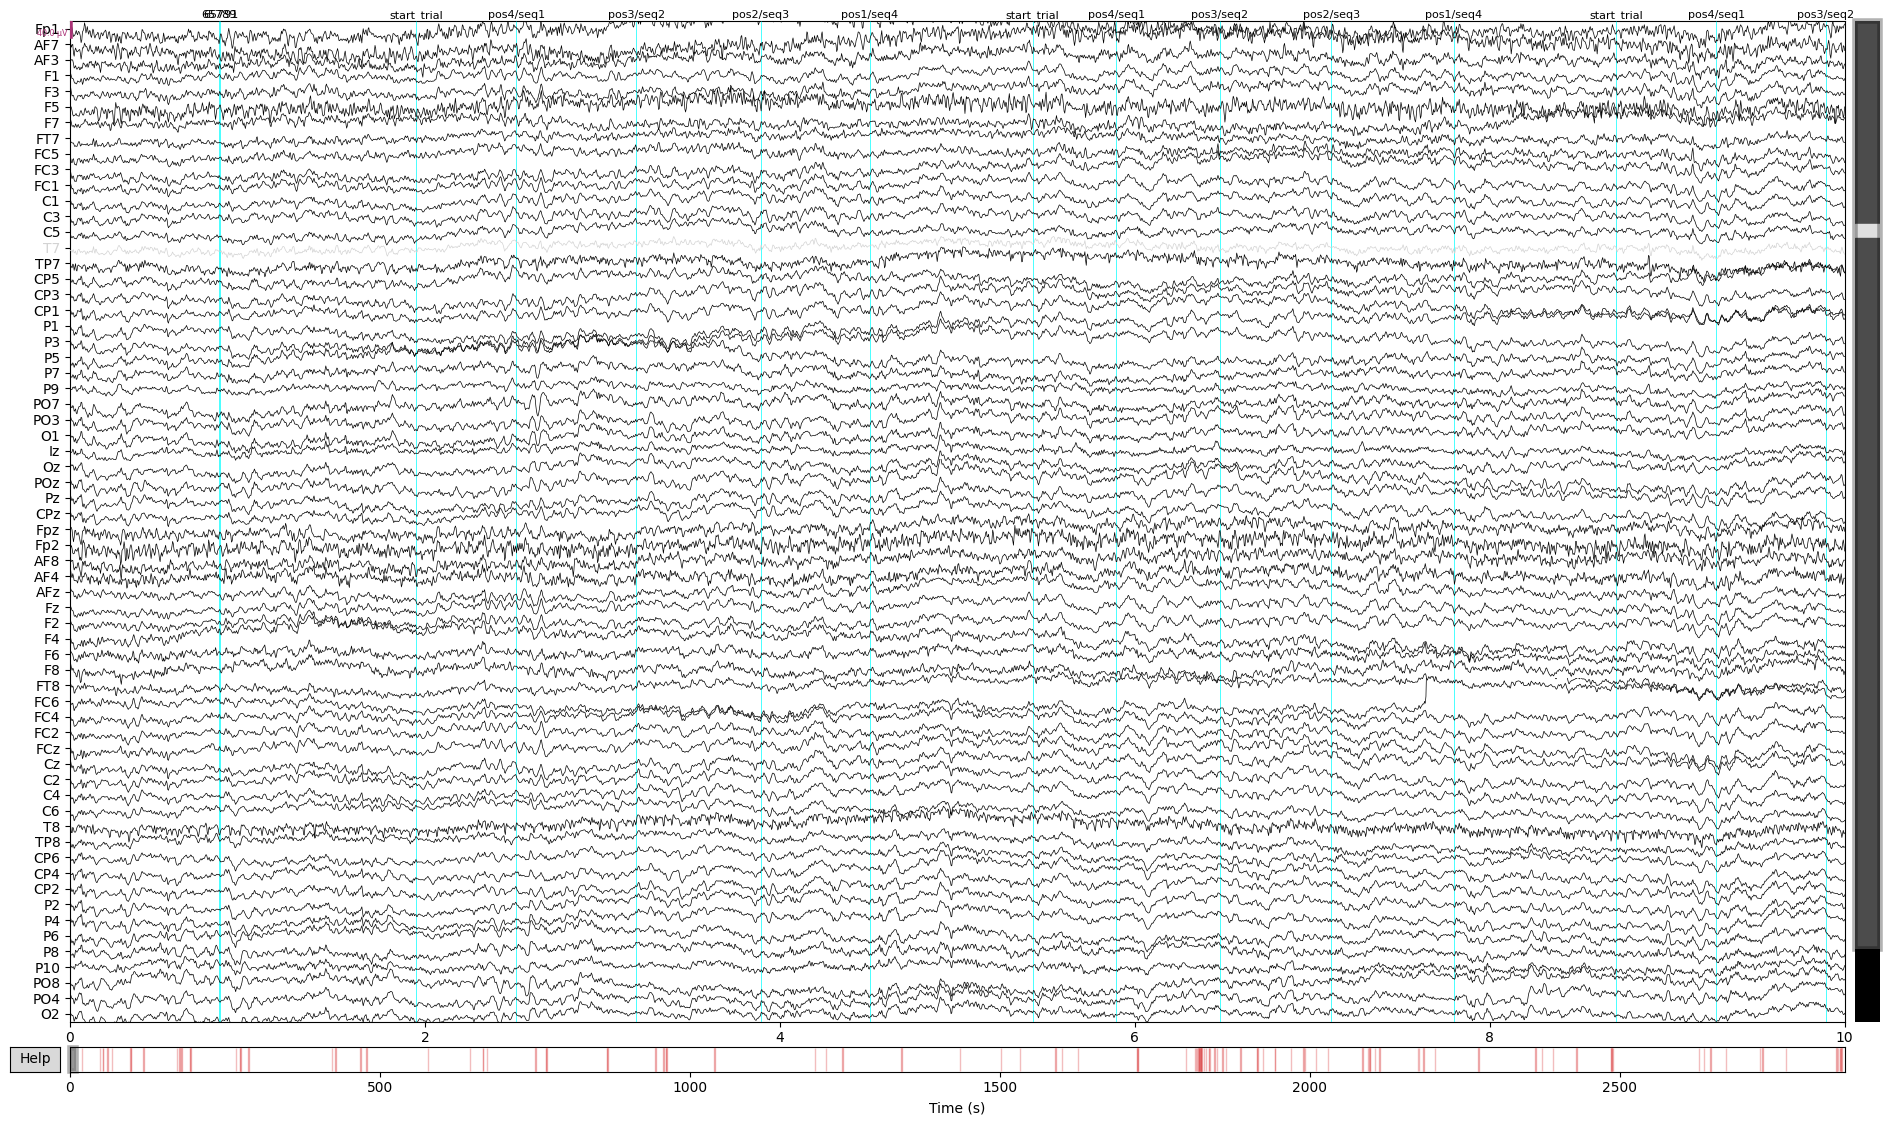

In [16]:
# revisit the data plot with events included
interp_filt_raw.plot(n_channels = 64,
         event_id = event_id,
         events = events)

In [17]:
interp_filt_events = mne.find_events(interp_filt_raw)

Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
4271 events found
Event IDs: [   12    14    21    23    32    34    41    43    99   255 65536 65789
 65791]


In [18]:

# # epoch data around response (hence the name of the file at the end: "response locked")
epochs_stimlock = mne.Epochs(interp_filt_raw, interp_filt_events, event_id = event_id,
    tmin = -0.1, tmax = 0.5, proj = False, baseline = (None,0), decim=decim, #from previous cell
    detrend = None, verbose = True, reject_by_annotation= False, preload = True)


Not setting metadata
4189 matching events found
Setting baseline interval to [-0.09765625, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 4189 events and 308 original time points (prior to decimation) ...
0 bad epochs dropped


In [19]:
nchan = len(interp_filt_raw.pick_types(eeg = True).ch_names)
nbad = len(interp_filt_raw.info['bads'])
ncomp = (nchan - nbad) -1
ica = mne.preprocessing.ICA(n_components = ncomp)
ica.fit(epochs_stimlock,decim=2, verbose='error')

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<ICA | epochs decomposition, method: fastica (fit in 90 iterations on 322553 samples), 62 ICA components (63 PCA components available), channel types: eeg, no sources marked for exclusion>

In [28]:
ica.plot_components()

[<MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 390x260 with 2 Axes>]

In [29]:
ica.exclude=[1]

In [30]:
ica.apply(epochs_stimlock)

Applying ICA to Epochs instance


C:\Users\mvmigem\AppData\Local\Temp\ipykernel_23436\1559164886.py:1: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  ica.apply(epochs_stimlock)


    Transforming to ICA space (62 components)
    Zeroing out 1 ICA component
    Projecting back using 63 PCA components


<Epochs |  4189 events (all good), -0.0976562 – 0.5 s, baseline -0.0976562 – 0 s, ~339.7 MB, data loaded,
 'start_trial': 840
 'pos1/seq2': 406
 'pos1/seq4': 426
 'pos2/seq1': 392
 'pos2/seq3': 448
 'pos3/seq2': 434
 'pos3/seq4': 403
 'pos4/seq1': 448
 'pos4/seq3': 392>

In [ ]:
epochs_stimlock.plot()

In [32]:
epochs_stimlock.save("C:/Users/mvmigem/Documents/data/project_1/pilot/clara/eeg/clara_main_clean_mastoidref-epo.fif", overwrite=True)

In [ ]:
evoked_pos1 = epochs_stimlock['pos1'].average()
evoked_pos2 = epochs_stimlock['pos2'].average()
evoked_pos3 = epochs_stimlock['pos3'].average()
evoked_pos4 = epochs_stimlock['pos4'].average()

evokeds_list = [evoked_pos1,evoked_pos2,evoked_pos3,evoked_pos4]
conds = ('pos1','pos2','pos3','pos4')
evoked_pos = dict(zip(conds, evokeds_list))

In [ ]:
post_electrodes = []
for i in range(32):
    electrode = 'A' + str(i+1)
    post_electrodes.append(electrode)

for i in np.arange(3,10):
    electrode = 'B' + str(i)
    post_electrodes.append(electrode)

In [ ]:
times = np.linspace(0.05, 0.15,4)
evoked_pos['pos4'].plot(picks= post_electrodes)

In [ ]:
mne.viz.plot_compare_evokeds(evoked_pos, picks= ' v ', vlines=[0.05,0.1])


In [ ]:
times = np.linspace(0.05, 0.15,4)
evoked_pos1.plot_joint(times = times)

In [ ]:
epochs_stimlock.info